# Criação e otimização dos modelos de classificação

<div>
<img src="imagens/opt.jpg" align="left" width="400"/>
</div>

---
### Rodrigo Fragoso 
- [**Linkedin**](https://www.linkedin.com/in/rodrigo-a-fragoso/) <br/>
- **Email** : rodrigoandradefragoso@gmail.com <br/>

### Objetivo
-  Com todos dados que foram anotados, baseado no *Active Learning*, será necessário treinar e otimizar os modelos para realizar o ensemble final.
-  O output esperado são os modelos treinados e otimizados para uso em produção.
---

<a id='top'></a>
## Sumário

* [1 - Importações das bibliotecas](#t1)

* [2 - Otimização Bayesiana de Hiperparâmetros](#t2)
    * [2.2 - Random Forest](#t2_2)
    * [2.3 - LightGBM](#t2_3)<br>
<br>

* [3 - Ensemble](#t3)

* [4 - Salvando modelos](#t4)

##     

<a id='t1'></a>
## 1 - Importações das bibliotecas
- [Sumário](#top)   
    - [Próximo](#t2)

### Para iniciarmos a extração será necessário o uso de algumas bibliotecas específicas, que serão importadas na célula abaixo:

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

##     

### Feito isto, os *datasets* anotados foram consolidados em apenas um para realizar o treinamento com os dados completos

In [2]:
df1 = pd.read_csv('./dados_tratados/dados_tratados_555_labels.csv',delimiter=';').dropna(subset=['y'])
df1 = df1[df1['y'].notnull()]
df1['novo'] = 0
df1.shape

(555, 97)

In [3]:
df2 = pd.read_csv("./dados_tratados/dados_tratados_active_learning_labels.csv",index_col=[0], delimiter=';')
df2 = df2[df2['y'].notnull()]
df2['novo'] = 1
df2=df2[df1.columns]
df2.shape

(200, 97)

In [4]:
df_updated=pd.concat([df1, df2])

In [5]:
X_up= df_updated.copy().drop(columns=['y','novo'])
y_up= df_updated['y'].copy()

from sklearn.feature_extraction.text import TfidfVectorizer
title= X_up['good_reasons_to_buy'].fillna(' ')
X_up=X_up.copy().drop(columns=['shoes_name','link','image','bad_reasons_to_buy','good_reasons_to_buy'])

### Aqui é feita uma verificação para garantir que eles foram combinados de maneira correta

In [6]:
print(X_up.shape)

(755, 90)


In [7]:
colunas_1=X_up.columns

##     

<a id='t2'></a>
## 2 - Otimização Bayesiana de Hiperparâmetros
- [Sumário](#top)   
    - [Próximo](#t2_1)

### Existem diferentes tecnicas para escolher/otimizar os hiperparametros de um modelo de *machine learning*, entre os mais utilizaddos estão a *Grid Search* e a *Random Search* que atuam da seguinte maneira:
* No *Grid Search* é criada uma matriz com diversas combinações de parâmetros, dentro de um intervalo com *steps* definidos pelo usuário. Com essa matriz, é feito o teste de todas configurações possíveis garantindo que escolhamos a melhor opção disponível dentro daquele universo, mas em contrapartida isso requer muito processamento e tempo, já que iremos realizar uma quantidade massiva de treinamentos;
* A *Random Search* faz uma pesquisa randômica dentro de um intervalo também definido pelo usuário. Basicamente, iremos "chutar" algumas combinações e analisar o seu resultado, podendo achar uma solução muito boa ou não, lembrando que o usuário irá escolher quantas vezes o algoritmo irá realizar  os "chutes";

### Para garantir um bom resultado e economizar tempo e processamento, foi utilizada uma outra solução: a otimização Bayesiana, que funciona da seguinte forma:
* Primeiro é feita uma *Random Search* para gerar alguns modelos que serão utilizados como base para otimização;
* Feito isso, o algoritmo "aprende" qual caminho seguir e faz sua busca pelo resultado ótimo;
* Obs: vale ressaltar que nada que garante que cheguemos ao otimo global, mas idealmente o algoritmo irá convergir.

<a id='t2_1'></a>
## 2.1 - Random Forest
- [Sumário](#top)   
    - [Anterior](#t2)
    - [Próximo](#t2_2)

### Aqui foi criada uma função para ser utilizada dentro da gp_minimize( ), que é o otimizador. Note que a função retorna um valor negativo, isso acontece porque estamos trabalhando em função de minimizar o nosso objetivo, então é necessária inverter o valor do objetivo para que ele seja maximizado.
### Obs: Foram otimizados tantos os hiperparâmetros do classificador quanto do TfidfVectorizer( )
### Na Random Forest, o objetivo foi otimizar a *Average Precision* e para avaliar os resultados, também foi utilizada a validação cruzada

In [8]:
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.sparse import hstack
from skopt import gp_minimize

count=0

def tune_rf(params):
    
    global count
    count=count+1

    max_features = params[0]
    max_depth = params[1]
    min_samples_leaf = params[2]
    min_samples_split = params[3]
    n_estimators = params[4]
    
    min_df = params[5]
    ngram_range = (1, params[6])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle = hstack([X_up, title_bow])
    
    rf= RandomForestClassifier(
                               max_features=max_features,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators,
                               class_weight="balanced", 
                               n_jobs=-1, 
                               random_state=1)
    resultados_aps=[]
    resultados_roc=[]
    
    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)
    for train,valid in kf.split(X_up_wtitle):

        Xtr, Xvld = X_up_wtitle.toarray()[train,:], X_up_wtitle.toarray()[valid,:]
        ytr, yvld = y_up.iloc[train], y_up.iloc[valid]

        rf.fit(Xtr,ytr)
        p=rf.predict(Xvld)

        aps=average_precision_score(yvld, p)
        resultados_aps.append(aps)
        
        roc=roc_auc_score(yvld, p)
        resultados_roc.append(roc)
    
    print('Iteração {n} / parametros:{params}'.format(n=count, 
                                                      params=params
                                                     ))
    print('APS = {aps} / AUC-ROC = {roc}'.format(aps=round(np.mean(resultados_aps),4),
                                                 roc=round(np.mean(resultados_roc),4)
                                                ))
    print('---')
          
    return -np.mean(resultados_aps)


space = [
         ('auto', 'sqrt'), # max_features
         (10, 70), # max_depth
         (1, 6), # min_samples_leaf
         (2, 10), # min_samples_split
         (500, 3000), # n_estimators
         (1, 20), # n_estimators
         (1, 5), # ngram_range
        ]
       

res_rf = gp_minimize(tune_rf,
                     space,
                     n_calls=99,
                     n_random_starts=40,
                     random_state=16,
#                      verbose=1
                 )

Iteração 1 / parametros:['auto', 13, 3, 3, 2261, 4, 4]
APS = 0.2714 / AUC-ROC = 0.5317
---
Iteração 2 / parametros:['sqrt', 61, 4, 3, 1986, 12, 4]
APS = 0.2747 / AUC-ROC = 0.5396
---
Iteração 3 / parametros:['auto', 53, 3, 3, 1270, 14, 3]
APS = 0.269 / AUC-ROC = 0.5333
---
Iteração 4 / parametros:['auto', 26, 2, 9, 648, 5, 4]
APS = 0.2656 / AUC-ROC = 0.524
---
Iteração 5 / parametros:['sqrt', 40, 3, 5, 741, 14, 4]
APS = 0.2702 / AUC-ROC = 0.5325
---
Iteração 6 / parametros:['sqrt', 69, 5, 3, 1523, 6, 4]
APS = 0.2756 / AUC-ROC = 0.5435
---
Iteração 7 / parametros:['sqrt', 20, 5, 3, 1219, 16, 3]
APS = 0.2963 / AUC-ROC = 0.5623
---
Iteração 8 / parametros:['auto', 56, 1, 7, 2167, 8, 3]
APS = 0.2573 / AUC-ROC = 0.5164
---
Iteração 9 / parametros:['sqrt', 53, 6, 10, 2414, 14, 4]
APS = 0.2957 / AUC-ROC = 0.5651
---
Iteração 10 / parametros:['auto', 53, 2, 7, 2556, 16, 5]
APS = 0.2671 / AUC-ROC = 0.5283
---
Iteração 11 / parametros:['sqrt', 70, 1, 3, 943, 8, 4]
APS = 0.2547 / AUC-ROC = 0.5131

### O argumento .x retorna os melhores hiiperparâmetros que foram encontrados na fase de otimização

In [9]:
res_rf.x

['auto', 22, 6, 3, 1418, 1, 1]

### Por último, foi feito o plot do nosso objetivo ao longo das iterações para garantir que ele estava convergindo para um valor coerente

Text(0.5, 1.0, 'Convergence Plot - Random Forest')

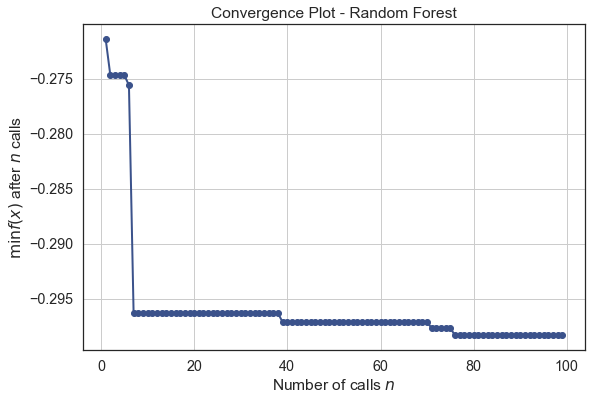

In [10]:
%matplotlib inline
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(9,6)})

from skopt.plots import plot_convergence
plot_convergence(res_rf)
# plt.ylim([-0.4,0])
plt.title('Convergence Plot - Random Forest')

##     

<a id='t2_2'></a>
## 2.2 - LightGBM
- [Sumário](#top)   
    - [Anterior](#t2_1)
    - [Próximo](#t3)

### O procedimento feito na RandomForest foi repetido para o LightGBM
### Nesse modelo, o objetivo foi otimizar a AUC - ROC, com o intuito de criar um *ensemble* mais robusto

In [11]:
from lightgbm import LGBMClassifier

count=0

def tune_lgbm(params):
    
    global count
    count=count+1

    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    min_df = params[6]
    ngram_range = (1, params[7])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle = hstack([X_up, title_bow])
    
    lgbm = LGBMClassifier(learning_rate=lr,
                          num_leaves=2 ** max_depth,
                          max_depth=max_depth,
                          min_child_samples=min_child_samples,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          bagging_freq=1,
                          n_estimators=n_estimators,
                          random_state=0, 
                          class_weight="balanced", 
                          n_jobs=-1)
    resultados_aps=[]
    resultados_roc=[]
    
    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)
    for train,valid in kf.split(X_up_wtitle):

        Xtr, Xvld = X_up_wtitle.toarray()[train,:], X_up_wtitle.toarray()[valid,:]
        ytr, yvld = y_up.iloc[train], y_up.iloc[valid]

        lgbm.fit(Xtr,ytr)
        p=lgbm.predict(Xvld)

        aps=average_precision_score(yvld, p)
        resultados_aps.append(aps)
        
        roc=roc_auc_score(yvld, p)
        resultados_roc.append(roc)
        
    print('Iteração {n} / parametros:{params}'.format(n=count, 
                                                      params=params
                                                     ))
    print('APS = {aps} / AUC-ROC = {roc}'.format(aps=round(np.mean(resultados_aps),4),
                                                 roc=round(np.mean(resultados_roc),4)
                                                ))
    print('---')

    return -np.mean(resultados_aps)
          
space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000), # n_estimators
          (1,5), # min_df
          (1,5)] # ngram_range
       

res_lgbm = gp_minimize(tune_lgbm, 
                       space,
                       n_calls=99, 
                       n_random_starts=40,
                       random_state=16,
                       #verbose=1
                 )

Iteração 1 / parametros:[0.004501034257432059, 2, 7, 0.18223484451094563, 0.7192409322554387, 239, 4, 4]
APS = 0.3594 / AUC-ROC = 0.6527
---
Iteração 2 / parametros:[0.048873535334964184, 7, 4, 0.6146125334241129, 0.5857379931995986, 754, 2, 4]
APS = 0.3141 / AUC-ROC = 0.5918
---
Iteração 3 / parametros:[0.005285302738556758, 2, 7, 0.7217109945776673, 0.4252835383400519, 275, 2, 2]
APS = 0.3635 / AUC-ROC = 0.6855
---
Iteração 4 / parametros:[0.043899935124562806, 2, 5, 0.7730836106749692, 0.8886409141192313, 552, 3, 3]
APS = 0.3037 / AUC-ROC = 0.5969
---
Iteração 5 / parametros:[0.0015593236533173003, 7, 17, 0.6333869656771897, 0.986077066924187, 760, 1, 3]
APS = 0.3401 / AUC-ROC = 0.6515
---
Iteração 6 / parametros:[0.0030901995236619615, 8, 16, 0.20174276846379458, 0.7927350384787077, 221, 2, 4]
APS = 0.3678 / AUC-ROC = 0.67
---
Iteração 7 / parametros:[0.014192887617413044, 1, 15, 0.08047844831608797, 0.655672774232068, 700, 3, 3]
APS = 0.3434 / AUC-ROC = 0.6526
---
Iteração 8 / par

In [12]:
res_lgbm.x

[0.001, 10, 20, 0.28121928887270203, 1.0, 1000, 1, 1]

### Aqui podemos verificar que a otimização convergiu, assim como no modelo anterior

Text(0.5, 1.0, 'Convergence Plot - LightGBM')

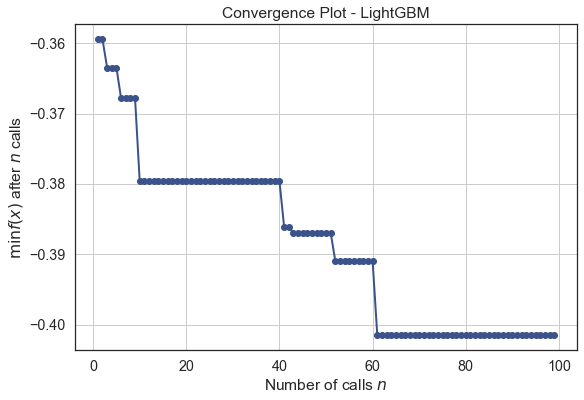

In [13]:
%matplotlib inline
sns.set(style='white',font_scale=1.3, rc={'figure.figsize':(9,6)})

from skopt.plots import plot_convergence
plot_convergence(res_lgbm)
# plt.ylim([-0.4,0])
plt.title('Convergence Plot - LightGBM')

##       

<a id='t3'></a>
## 3 - Ensemble
- [Sumário](#top)   
    - [Anterior](#t2_2)
    - [Próximo](#t4)

### Neste tópico, foi utilizada uma técnica de *ensemble* que tem como principal objetivo combinar diversos modelos de *machine learning* e aumentar sua performance e/ou capacidade de generalização. Para isso, é feita uma média ponderada dos resultados de "probabilidade" de cada um dos modelos utilizados, lembrando que os pesos utilizados na média ponderada são definidos pelo usuário e podem ser testados manualmente ou de forma automátic, a depender da complexidade e quantidade de modelos no *ensemble*.

### Encontrados os valores ótimos para ambos os modelos, eles foram treinados com todos os dados:

In [14]:
def tune_ensemble(params_rf,params_lgbm,rf_weight,lgbm_weight):

    max_features = params_rf[0]
    max_depth = params_rf[1]
    min_samples_leaf = params_rf[2]
    min_samples_split = params_rf[3]
    n_estimators = params_rf[4]
    
    min_df = params_rf[5]
    ngram_range = (1, params_rf[6])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle_rf = hstack([X_up, title_bow])
    
    rf= RandomForestClassifier(
                               max_features=max_features,
                               max_depth=max_depth,
                               min_samples_leaf=min_samples_leaf,
                               min_samples_split=min_samples_split,
                               n_estimators=n_estimators,
                               class_weight="balanced", 
                               n_jobs=-1, 
                               random_state=1)
    
    lr = params_lgbm[0]
    max_depth = params_lgbm[1]
    min_child_samples = params_lgbm[2]
    subsample = params_lgbm[3]
    colsample_bytree = params_lgbm[4]
    n_estimators = params_lgbm[5]
    
    min_df = params_lgbm[6]
    ngram_range = (1, params_lgbm[7])
    
    title_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
    title_bow = title_vec.fit_transform(title)
    
    X_up_wtitle_lgbm = hstack([X_up, title_bow])
    
    lgbm = LGBMClassifier(learning_rate=lr,
                          num_leaves=2 ** max_depth,
                          max_depth=max_depth,
                          min_child_samples=min_child_samples,
                          subsample=subsample,
                          colsample_bytree=colsample_bytree,
                          bagging_freq=1,
                          n_estimators=n_estimators,
                          random_state=0, 
                          class_weight="balanced", 
                          n_jobs=-1)
       
    resultados_aps=[]
    resultados_roc=[]
    
    kf= RepeatedKFold(n_splits=2, n_repeats=1, random_state=5)
    for train,valid in kf.split(X_up_wtitle_rf):

        Xtr_rf, Xvld_rf = X_up_wtitle_rf.toarray()[train,:], X_up_wtitle_rf.toarray()[valid,:]
        Xtr_lgbm, Xvld_lgbm = X_up_wtitle_lgbm.toarray()[train,:], X_up_wtitle_lgbm.toarray()[valid,:]
        
        ytr_rf, yvld_rf = y_up.iloc[train], y_up.iloc[valid]  
        ytr_lgbm, yvld_lgbm = y_up.iloc[train], y_up.iloc[valid]

        rf.fit(Xtr_rf,ytr_rf)
        lgbm.fit(Xtr_lgbm,ytr_lgbm)
        
        p=rf.predict(Xvld_rf)
        p2=lgbm.predict(Xvld_lgbm)
        p_ensemble= rf_weight*p + lgbm_weight*p2
        
        aps=average_precision_score(yvld_lgbm, p_ensemble)
        resultados_aps.append(aps)
        
        roc=roc_auc_score(yvld_lgbm, p_ensemble)
        resultados_roc.append(roc)
        
    print('Peso RF: {}'.format(rf_weight),'Peso lGBM: {}'.format(lgbm_weight))
    print('APS: {}'.format(round(np.mean(resultados_aps),4)),'AUC: {}'.format(round(np.mean(resultados_roc),4)))
    print('')
                                                                                 

In [15]:
params_lgbm=res_lgbm.x
params_rf=res_rf.x

### Por fim, foram testadas todas combinações de pesos dentro de um intervalo definido:

In [16]:
from itertools import combinations 
  
def findPairs(lst, K): 
    return [pair for pair in combinations(lst, 2) if sum(pair) == K] 

In [17]:
numbers = np.arange(0.05, 1.05, 0.05).tolist()
pares=findPairs(numbers,1)
for x,y in pares:
    tune_ensemble(params_rf,params_lgbm,round(x,2),round(y,2))
    tune_ensemble(params_rf,params_lgbm,round(y,2),round(x,2))

Peso RF: 0.05 Peso lGBM: 0.95
APS: 0.4129 AUC: 0.7148

Peso RF: 0.95 Peso lGBM: 0.05
APS: 0.4062 AUC: 0.7091

Peso RF: 0.15 Peso lGBM: 0.85
APS: 0.4129 AUC: 0.7148

Peso RF: 0.85 Peso lGBM: 0.15
APS: 0.4062 AUC: 0.7091

Peso RF: 0.2 Peso lGBM: 0.8
APS: 0.4129 AUC: 0.7148

Peso RF: 0.8 Peso lGBM: 0.2
APS: 0.4062 AUC: 0.7091

Peso RF: 0.25 Peso lGBM: 0.75
APS: 0.4129 AUC: 0.7148

Peso RF: 0.75 Peso lGBM: 0.25
APS: 0.4062 AUC: 0.7091

Peso RF: 0.3 Peso lGBM: 0.7
APS: 0.4129 AUC: 0.7148

Peso RF: 0.7 Peso lGBM: 0.3
APS: 0.4062 AUC: 0.7091

Peso RF: 0.4 Peso lGBM: 0.6
APS: 0.4129 AUC: 0.7148

Peso RF: 0.6 Peso lGBM: 0.4
APS: 0.4062 AUC: 0.7091

Peso RF: 0.45 Peso lGBM: 0.55
APS: 0.4129 AUC: 0.7148

Peso RF: 0.55 Peso lGBM: 0.45
APS: 0.4062 AUC: 0.7091



### Como o *ensemble* obteve resultados sem muita variação, optei por utilizar 50% de cada modelo, já que cada um otimiza uma métrica, a fim de aumentar a sua capacidade de generalização quando em produção.

##       

<a id='t4'></a>
## 4 - Salvando modelos
- [Sumário](#top)   
    - [Anterior](#t3)

### Para utilizar os modelos no deploy, eles foram treinados com todos os dados anotados:

In [21]:
params=params_lgbm

lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

min_df = params[6]
ngram_range = (1, params[7])


title_vec_lgbm = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
title_bow = title_vec_lgbm.fit_transform(title)

X_up_wtitle = hstack([X_up, title_bow])

lgbm = LGBMClassifier(learning_rate=lr,
                      num_leaves=2 ** max_depth,
                      max_depth=max_depth,
                      min_child_samples=min_child_samples,
                      subsample=subsample,
                      colsample_bytree=colsample_bytree,
                      bagging_freq=1,
                      n_estimators=n_estimators,
                      random_state=0, 
                      class_weight="balanced", 
                      n_jobs=-1)

lgbm.fit(X_up_wtitle,y_up)

LGBMClassifier(bagging_freq=1, boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.001, max_depth=10, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
               n_jobs=-1, num_leaves=1024, objective=None, random_state=0,
               reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.28121928887270203, subsample_for_bin=200000,
               subsample_freq=0)

In [23]:
params=params_rf

max_features = params[0]
max_depth = params[1]
min_samples_leaf = params[2]
min_samples_split = params[3]
n_estimators = params[4]

min_df = params[5]
ngram_range = (1, params[6])

title_vec_rf = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
title_bow = title_vec_rf.fit_transform(title)

X_up_wtitle = hstack([X_up, title_bow])

rf= RandomForestClassifier(
                           max_features=max_features,
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           min_samples_split=min_samples_split,
                           n_estimators=n_estimators,
                           class_weight="balanced", 
                           n_jobs=-1)

rf.fit(X_up_wtitle,y_up)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=22, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=6, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=1418,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

### Feito isso, eles foram salvos na extensão .pkl.z com o auxílio da biblioteca joblib

In [18]:
import joblib as jb

In [24]:
jb.dump(lgbm, "lgbm_20200727.pkl.z")
jb.dump(title_vec_lgbm, "title_vectorizer_lgbm_20200727.pkl.z")

jb.dump(rf, "random_forest_20200727.pkl.z")
jb.dump(title_vec_rf, "title_vectorizer_rf_20200727.pkl.z")

['title_vectorizer_rf_20200727.pkl.z']

##       

##       